<a href="https://colab.research.google.com/github/Ajbina/AdminPanel/blob/master/Air_quality_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout

# Clone Dataset

In [ ]:
# Clone dataset
!git clone https://github.com/muhammadraflij/company-capstone.git

fatal: destination path 'company-capstone' already exists and is not an empty directory.


In [ ]:
# Unzip dataset
!unzip "/content/company-capstone/Dataset/aqi_34prov1.zip" -d "/content/dataset"

Archive:  /content/company-capstone/Dataset/aqi_34prov1.zip
replace /content/dataset/aqi_34prov.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/aqi_34prov.csv  


In [ ]:
# define dataframe
df = pd.read_csv("dataset/aqi_34prov.csv")

In [ ]:
df

,Unnamed: 0,datetime,city,lat,lon,aqi,pm10,pm25,o3,so2,no2,co,ts
0,0,2022-01-16:17,Bengkulu,-3.57710,102.36053,9.0,3.84,1.84,19.36,0.15,3.57,534.34,1642352400
1,1,2022-01-16:18,Bengkulu,-3.57710,102.36053,8.0,3.97,1.88,17.28,0.13,3.31,536.56,1642356000
2,2,2022-01-16:19,Bengkulu,-3.57710,102.36053,8.0,3.96,1.87,16.38,0.12,2.89,536.28,1642359600
3,3,2022-01-16:20,Bengkulu,-3.57710,102.36053,8.0,3.95,1.86,15.49,0.11,2.46,536.00,1642363200
4,4,2022-01-16:21,Bengkulu,-3.57710,102.36053,8.0,3.94,1.85,14.60,0.11,2.03,535.73,1642366800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98051,98051,2022-05-16:13,yogyakarta,-7.80139,110.36470,136.0,77.18,48.91,10.56,10.72,21.54,1509.69,1652706000
98052,98052,2022-05-16:14,yogyakarta,-7.80139,110.36470,157.0,94.78,60.84,8.65,12.46,21.49,1777.14,1652709600
98053,98053,2022-05-16:15,yogyakarta,-7.80139,110.36470,173.0,112.38,72.78,6.74,14.19,21.43,2044.59,1652713200
98054,98054,2022-05-16:16,yogyakarta,-7.80139,110.36470,173.0,108.57,73.06,5.66,13.63,21.43,2000.80,1652716800


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98056 entries, 0 to 98055
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  98056 non-null  int64  
 1   datetime    98056 non-null  object 
 2   city        98056 non-null  object 
 3   lat         98056 non-null  float64
 4   lon         98056 non-null  float64
 5   aqi         96258 non-null  float64
 6   pm10        96254 non-null  float64
 7   pm25        96258 non-null  float64
 8   o3          96254 non-null  float64
 9   so2         96254 non-null  float64
 10  no2         96254 non-null  float64
 11  co          96254 non-null  float64
 12  ts          98056 non-null  int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 9.7+ MB


# Set datetime column to datetime format and set to index

In [ ]:
# split value in datetime column
new = df["datetime"].str.split(":", n = 1, expand = True)

df["date"]= new[0]
df["time"]= new[1]

df['datetime'] = df.date.map(str) + " " + df.time
df = df.drop(['date', 'time'], axis=1)

In [ ]:
# Datetime column to datetime format
df.datetime = pd.to_datetime(df.datetime)

# Set datetime column to index
df = df.set_index('datetime')

# Extracted year, month, day and hour from the index and stored in new columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.dayofweek
df['hour'] = df.index.hour

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98056 entries, 2022-01-16 17:00:00 to 2022-05-16 17:00:00
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  98056 non-null  int64  
 1   city        98056 non-null  object 
 2   lat         98056 non-null  float64
 3   lon         98056 non-null  float64
 4   aqi         96258 non-null  float64
 5   pm10        96254 non-null  float64
 6   pm25        96258 non-null  float64
 7   o3          96254 non-null  float64
 8   so2         96254 non-null  float64
 9   no2         96254 non-null  float64
 10  co          96254 non-null  float64
 11  ts          98056 non-null  int64  
 12  year        98056 non-null  int64  
 13  month       98056 non-null  int64  
 14  day         98056 non-null  int64  
 15  hour        98056 non-null  int64  
dtypes: float64(9), int64(6), object(1)
memory usage: 12.7+ MB
None


In [ ]:
df

,Unnamed: 0,city,lat,lon,aqi,pm10,pm25,o3,so2,no2,co,ts,year,month,day,hour
datetime,,,,,,,,,,,,,,,,
2022-01-16 17:00:00,0,Bengkulu,-3.57710,102.36053,9.0,3.84,1.84,19.36,0.15,3.57,534.34,1642352400,2022,1,6,17
2022-01-16 18:00:00,1,Bengkulu,-3.57710,102.36053,8.0,3.97,1.88,17.28,0.13,3.31,536.56,1642356000,2022,1,6,18
2022-01-16 19:00:00,2,Bengkulu,-3.57710,102.36053,8.0,3.96,1.87,16.38,0.12,2.89,536.28,1642359600,2022,1,6,19
2022-01-16 20:00:00,3,Bengkulu,-3.57710,102.36053,8.0,3.95,1.86,15.49,0.11,2.46,536.00,1642363200,2022,1,6,20
2022-01-16 21:00:00,4,Bengkulu,-3.57710,102.36053,8.0,3.94,1.85,14.60,0.11,2.03,535.73,1642366800,2022,1,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16 13:00:00,98051,yogyakarta,-7.80139,110.36470,136.0,77.18,48.91,10.56,10.72,21.54,1509.69,1652706000,2022,5,0,13
2022-05-16 14:00:00,98052,yogyakarta,-7.80139,110.36470,157.0,94.78,60.84,8.65,12.46,21.49,1777.14,1652709600,2022,5,0,14
2022-05-16 15:00:00,98053,yogyakarta,-7.80139,110.36470,173.0,112.38,72.78,6.74,14.19,21.43,2044.59,1652713200,2022,5,0,15


## filter dataset

In [ ]:
dataset = df.query("city == 'bandung'")

In [ ]:
dataset

,Unnamed: 0,city,lat,lon,aqi,pm10,pm25,o3,so2,no2,co,ts,year,month,day,hour
datetime,,,,,,,,,,,,,,,,
2022-01-16 17:00:00,63448,bandung,-6.92222,107.60694,68.0,43.07,20.32,99.36,7.65,4.69,832.52,1642352400,2022,1,6,17
2022-01-16 18:00:00,63449,bandung,-6.92222,107.60694,73.0,46.75,22.48,97.27,7.97,4.66,846.15,1642356000,2022,1,6,18
2022-01-16 19:00:00,63450,bandung,-6.92222,107.60694,74.0,46.88,23.30,94.65,8.23,4.95,833.91,1642359600,2022,1,6,19
2022-01-16 20:00:00,63451,bandung,-6.92222,107.60694,76.0,47.01,24.11,92.03,8.49,5.24,821.67,1642363200,2022,1,6,20
2022-01-16 21:00:00,63452,bandung,-6.92222,107.60694,78.0,47.14,24.93,89.41,8.75,5.53,809.43,1642366800,2022,1,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16 13:00:00,66327,bandung,-6.92222,107.60694,214.0,151.94,103.38,1.90,15.84,37.08,2458.23,1652706000,2022,5,0,13
2022-05-16 14:00:00,66328,bandung,-6.92222,107.60694,242.0,180.00,124.41,1.11,16.92,37.60,2767.62,1652709600,2022,5,0,14
2022-05-16 15:00:00,66329,bandung,-6.92222,107.60694,270.0,208.06,145.45,0.33,18.00,38.12,3077.00,1652713200,2022,5,0,15


# EDA

## How does the month affect the aqi?


Text(0, 0.5, 'aqi')

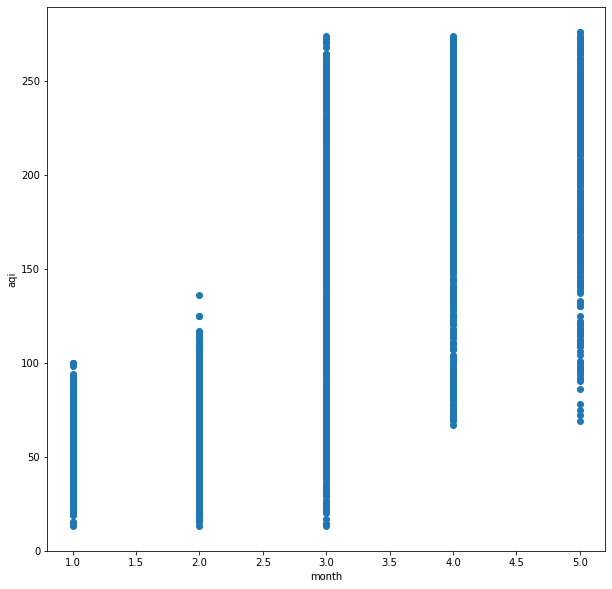

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x='month',y='aqi',data=dataset)
plt.xlabel('month')
plt.ylabel('aqi')

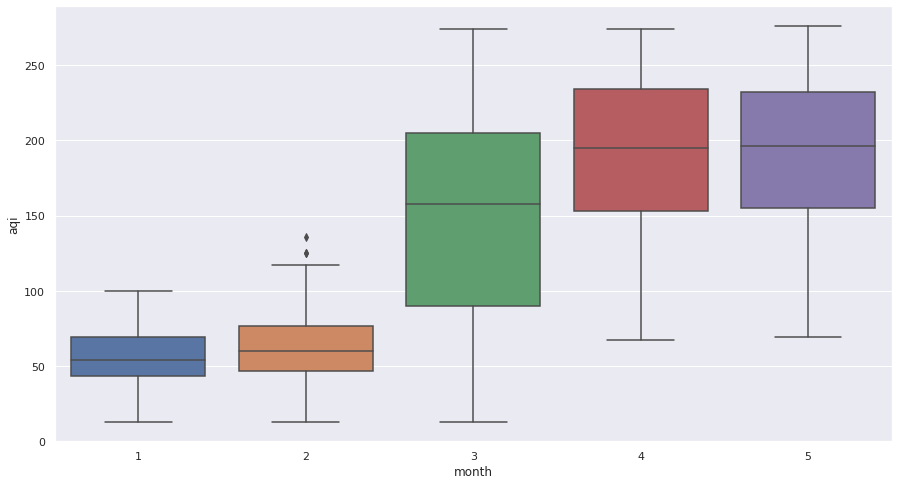

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="month", y="aqi", data=dataset)

## How does the day affect the aqi?


Text(0, 0.5, 'aqi')

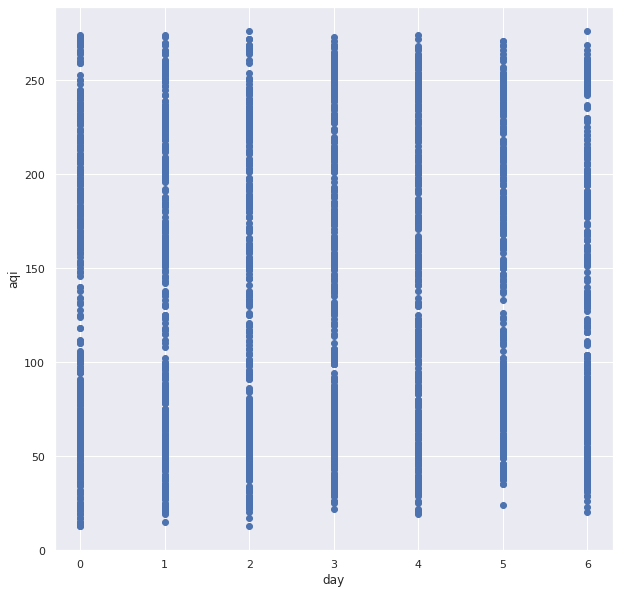

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x='day',y='aqi',data=dataset)
plt.xlabel('day')
plt.ylabel('aqi')

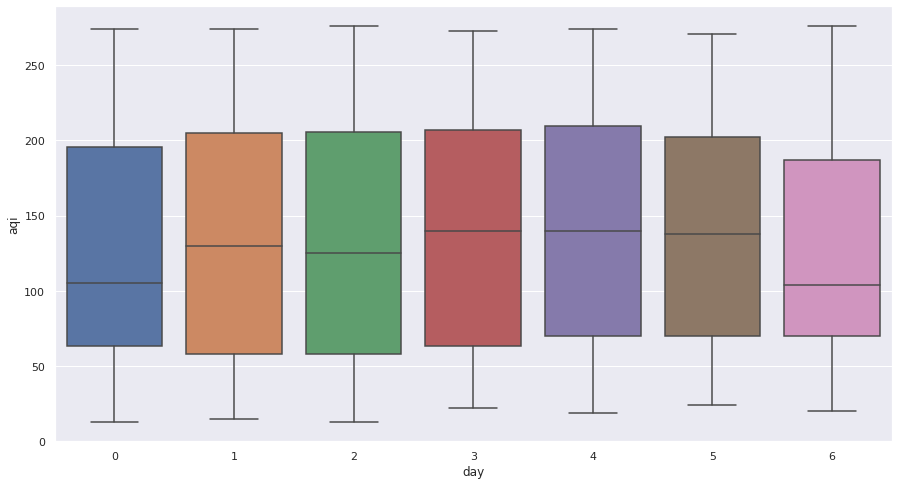

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="day", y="aqi", data=dataset)

## How does the hour affect the aqi?


Text(0, 0.5, 'aqi')

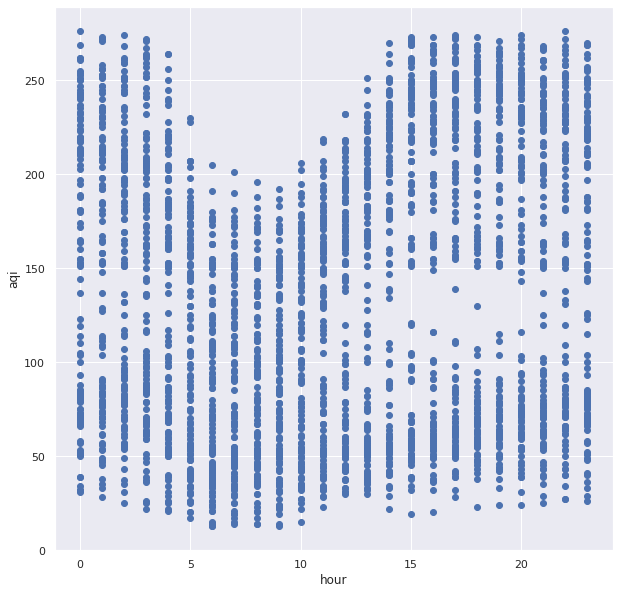

In [ ]:
# UTC Time
plt.figure(figsize=(10,10))
plt.scatter(x='hour',y='aqi',data=dataset)
plt.xlabel('hour')
plt.ylabel('aqi')

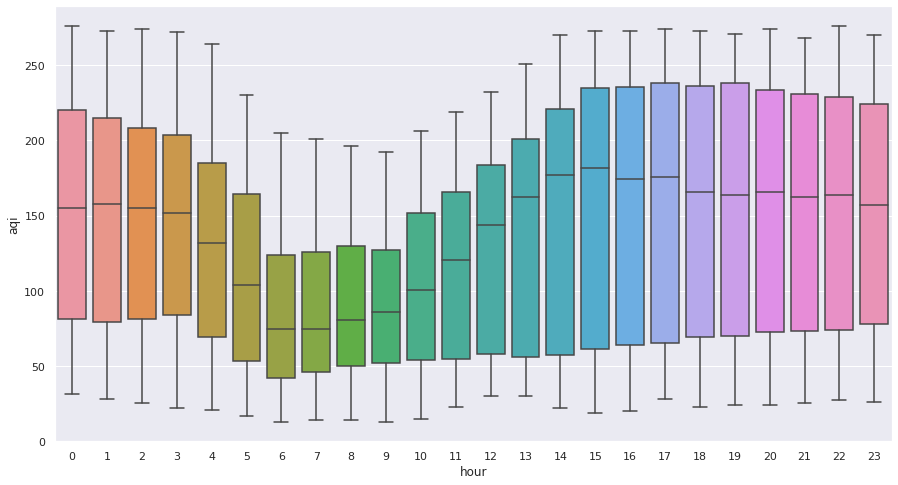

In [ ]:
sns.set_theme(style="whitegrid")
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x="hour", y="aqi", data=dataset)

## Correlation

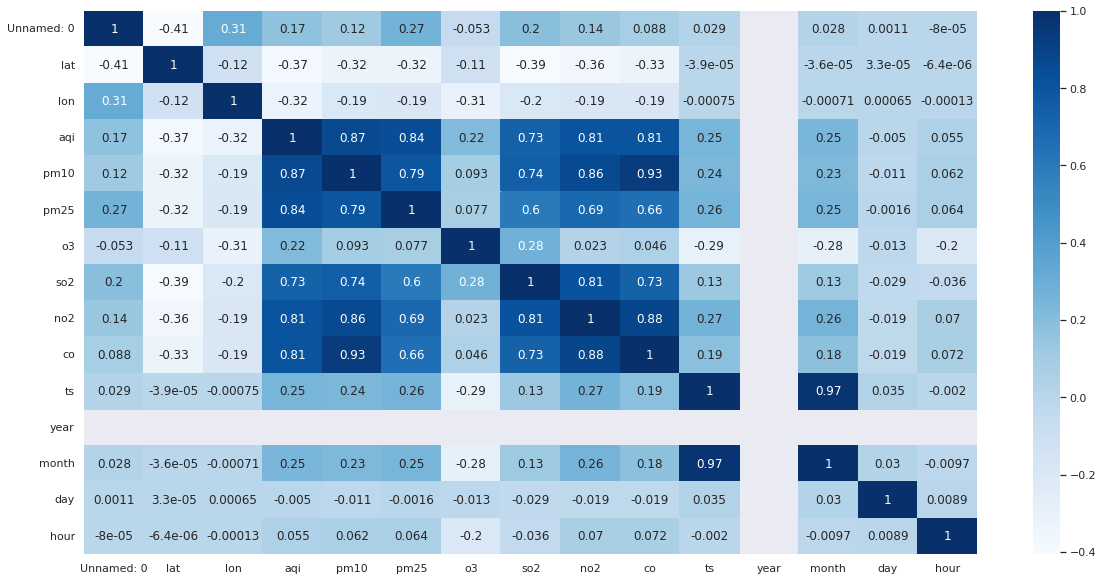

In [ ]:
# Correlation
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),cbar=True,annot=True,cmap='Blues')

# Data Cleaning

## Drop unnused columns

In [ ]:
df_input = dataset.drop(['city', 'year', 'month', 'day', 'hour', 'ts', 'lat', 'lon','Unnamed: 0'], axis=1)

In [ ]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2884 entries, 2022-01-16 17:00:00 to 2022-05-16 17:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aqi     2831 non-null   float64
 1   pm10    2831 non-null   float64
 2   pm25    2831 non-null   float64
 3   o3      2831 non-null   float64
 4   so2     2831 non-null   float64
 5   no2     2831 non-null   float64
 6   co      2831 non-null   float64
dtypes: float64(7)
memory usage: 180.2 KB


In [ ]:
df_input

,aqi,pm10,pm25,o3,so2,no2,co
datetime,,,,,,,
2022-01-16 17:00:00,68.0,43.07,20.32,99.36,7.65,4.69,832.52
2022-01-16 18:00:00,73.0,46.75,22.48,97.27,7.97,4.66,846.15
2022-01-16 19:00:00,74.0,46.88,23.30,94.65,8.23,4.95,833.91
2022-01-16 20:00:00,76.0,47.01,24.11,92.03,8.49,5.24,821.67
2022-01-16 21:00:00,78.0,47.14,24.93,89.41,8.75,5.53,809.43
...,...,...,...,...,...,...,...
2022-05-16 13:00:00,214.0,151.94,103.38,1.90,15.84,37.08,2458.23
2022-05-16 14:00:00,242.0,180.00,124.41,1.11,16.92,37.60,2767.62
2022-05-16 15:00:00,270.0,208.06,145.45,0.33,18.00,38.12,3077.00


## Handling missing values

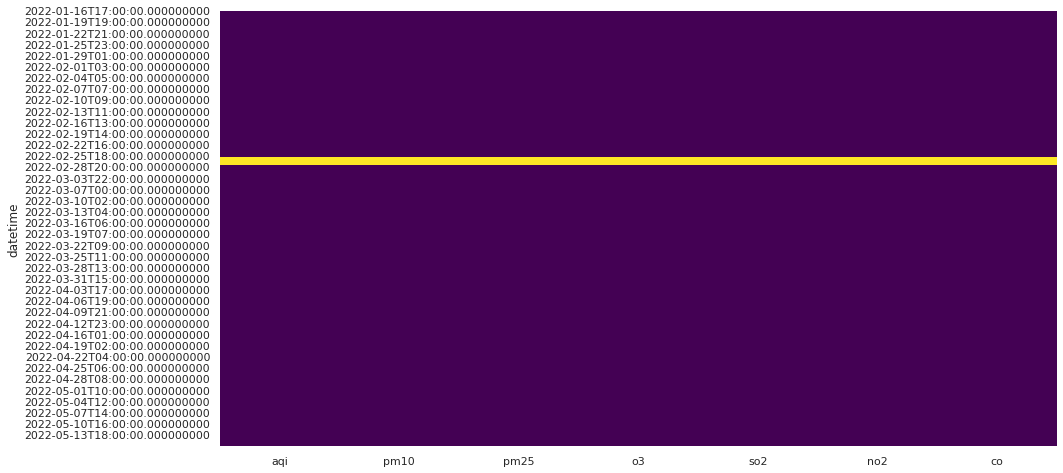

In [ ]:
# Plot null data
sns.heatmap(df_input.isnull(),cbar=False,cmap='viridis')

In [ ]:
# Total null data
print(df_input.isnull().sum())
print('shape:', df_input.shape)

aqi     53
pm10    53
pm25    53
o3      53
so2     53
no2     53
co      53
dtype: int64
shape: (2884, 7)


In [ ]:
# Drop null value
df_input.dropna(inplace=True)

In [ ]:
# Total null data
print(df_input.isnull().sum())
print('shape:', df_input.shape)

aqi     0
pm10    0
pm25    0
o3      0
so2     0
no2     0
co      0
dtype: int64
shape: (2831, 7)


In [ ]:
df_input.describe()

,aqi,pm10,pm25,o3,so2,no2,co
count,2831.000000,2831.000000,2831.000000,2831.000000,2831.000000,2831.000000,2831.000000
mean,133.950548,81.185267,58.196171,47.374829,9.159838,18.035793,1415.721254
std,74.797751,57.702009,46.870872,42.142147,3.905329,14.134466,758.768276
min,13.000000,0.130000,0.050000,0.330000,1.520000,0.610000,384.730000
25%,65.000000,32.870000,16.705000,10.975000,6.300000,5.930000,746.290000
50%,125.000000,63.990000,44.840000,35.040000,8.580000,13.140000,1187.480000
75%,202.000000,131.430000,98.130000,76.705000,11.705000,29.130000,2103.095000
max,276.000000,259.940000,220.380000,208.850000,22.940000,59.340000,3392.650000


# Prepare input for training model



In [ ]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# split dataset to train and test
total_dataset = len(df_input)
df_train = df_input[:int(total_dataset*0.76)]
df_test = df_input[int(total_dataset*0.76):total_dataset]

# scaled
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.fit_transform(df_test)

print('Data for train:', df_train.shape)
print('Total day for train:', df_train.shape[0]/24)
print('\nData for test:', df_test.shape)
print('Total day for test:', df_test.shape[0]/24)

Data for train: (2151, 7)
Total day for train: 89.625

Data for test: (680, 7)
Total day for test: 28.333333333333332


In [ ]:
# Choose a number of time steps
# n_steps_in history data for predict n_steps_out forecast data
n_steps_in, n_steps_out = 6, 3

# Convert into input/output
x_train, y_train = split_sequences(df_train_scaled, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(df_test_scaled, n_steps_in, n_steps_out)

# The dataset knows the number of features, e.g. 2
n_features = x_train.shape[2]

In [ ]:
# Look at the x_train structure
print('Data input structure for training')
print(x_train[0])

print('\nData output structure for validation')
print(y_train[0])

Data input structure for training
[[0.21072797 0.16527462 0.09199837 0.47476734 0.28618114 0.06947046
  0.15542867]
 [0.22988506 0.17943882 0.10180184 0.46474144 0.30112045 0.06895965
  0.16015967]
 [0.23371648 0.17993919 0.10552353 0.45217308 0.31325864 0.0738975
  0.15591114]
 [0.24137931 0.18043955 0.10919984 0.43960472 0.32539683 0.07883535
  0.15166262]
 [0.24904215 0.18093992 0.11292153 0.42703636 0.33753501 0.0837732
  0.14741409]
 [0.24521073 0.1765521  0.1110153  0.38213566 0.36507937 0.09620296
  0.14181534]]

Data output structure for validation
[[0.24137931 0.17220276 0.10910906 0.33723496 0.39262372 0.108803
  0.13621659]
 [0.23754789 0.16781494 0.10724822 0.29233426 0.42016807 0.12123276
  0.13061437]
 [0.24904215 0.1802471  0.11323923 0.35896575 0.48646125 0.11646518
  0.12955224]]


In [ ]:
print('Total features:', n_features)
print('Total train data:', x_train.shape)
print('Total validation train data:', y_train.shape)
print('Total test data:', x_test.shape)
print('Total validation test data:', y_test.shape)

Total features: 7
Total train data: (2143, 6, 7)
Total validation train data: (2143, 3, 7)
Total test data: (672, 6, 7)
Total validation test data: (672, 3, 7)


# Train

In [ ]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               166400    
                                                                 
 repeat_vector (RepeatVector  (None, 3, 200)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 3, 200)            320800    
                                                                 
 time_distributed (TimeDistr  (None, 3, 7)             1407      
 ibuted)                                                         
                                                                 
Total params: 488,607
Trainable params: 488,607
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
epoch = 50

model.compile(optimizer='adam', loss='mse',
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test))

Epoch 1/50
67/67 [==============================] - 5s 39ms/step - loss: 0.0444 - mean_absolute_error: 0.1500 - val_loss: 0.0477 - val_mean_absolute_error: 0.1782
Epoch 2/50
67/67 [==============================] - 2s 32ms/step - loss: 0.0140 - mean_absolute_error: 0.0876 - val_loss: 0.0301 - val_mean_absolute_error: 0.1374
Epoch 3/50
67/67 [==============================] - 2s 32ms/step - loss: 0.0094 - mean_absolute_error: 0.0714 - val_loss: 0.0199 - val_mean_absolute_error: 0.1065
Epoch 4/50
67/67 [==============================] - 2s 32ms/step - loss: 0.0072 - mean_absolute_error: 0.0616 - val_loss: 0.0177 - val_mean_absolute_error: 0.0983
Epoch 5/50
67/67 [==============================] - 2s 32ms/step - loss: 0.0061 - mean_absolute_error: 0.0559 - val_loss: 0.0167 - val_mean_absolute_error: 0.0983
Epoch 6/50
67/67 [==============================] - 2s 32ms/step - loss: 0.0055 - mean_absolute_error: 0.0530 - val_loss: 0.0143 - val_mean_absolute_error: 0.0874
Epoch 7/50
67/67 [====

# Test model


In [ ]:
predictions = model.predict_generator(x_test)
print(predictions.shape)
print(y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


(672, 3, 7)
(672, 3, 7)


In [ ]:
# reshape according to predictions shape
predictions = np.reshape(predictions, (672*3, 7))
real = np.reshape(y_test, (672*3, 7))

# rescale predictions
predictions = pd.DataFrame(predictions)
predictions = scaler.inverse_transform(predictions)
predictions = pd.DataFrame(predictions)

real = pd.DataFrame(real)
real = scaler.inverse_transform(real)
real = pd.DataFrame(real)

print(predictions.shape)
print(real.shape)

(2016, 7)
(2016, 7)


In [ ]:
predictions

,0,1,2,3,4,5,6
0,271.941895,213.546967,152.957687,20.260595,18.026434,46.150578,3029.333740
1,255.191574,208.303894,152.819412,19.138870,16.942392,43.794758,2914.188477
2,254.285370,203.932205,151.265106,21.070692,15.785549,41.602909,2841.131348
3,270.361938,207.180252,150.108963,17.735081,17.236496,45.130199,2968.031738
4,258.879791,196.393829,146.342880,16.447605,15.870724,42.311768,2786.671387
...,...,...,...,...,...,...,...
2011,254.684372,183.451004,120.557983,1.121093,18.779148,40.906261,3161.859619
2012,258.719208,188.607819,125.523727,-1.013575,18.786743,39.051350,3277.729004
2013,265.104858,198.746185,132.716461,6.539531,18.871628,41.314953,3235.157959
2014,260.001770,196.546066,133.786453,2.679813,18.191893,38.835262,3214.110352


In [ ]:
real

,0,1,2,3,4,5,6
0,273.0,193.18,147.59,20.49,16.58,43.01,2790.27
1,273.0,189.48,147.76,18.60,16.05,43.48,2856.80
2,273.0,185.77,147.94,16.71,15.53,43.94,2923.33
3,273.0,189.48,147.76,18.60,16.05,43.48,2856.80
4,273.0,185.77,147.94,16.71,15.53,43.94,2923.33
...,...,...,...,...,...,...,...
2011,270.0,208.06,145.45,0.33,18.00,38.12,3077.00
2012,265.0,198.47,141.72,0.34,16.71,38.15,2967.81
2013,270.0,208.06,145.45,0.33,18.00,38.12,3077.00
2014,265.0,198.47,141.72,0.34,16.71,38.15,2967.81


In [ ]:
df_final = pd.DataFrame()

In [ ]:
df_final['aqi'] = real[0]
df_final['pm10'] = real[1]
df_final['pm25'] = real[2]
df_final['o3'] = real[3]
df_final['so2'] = real[4]
df_final['no2'] = real[5]
df_final['co'] = real[6]

df_final['aqi_pred'] = predictions[0]
df_final['pm10_pred'] = predictions[1]
df_final['pm25_pred'] = predictions[2]
df_final['o3_pred'] = predictions[3]
df_final['so2_pred'] = predictions[4]
df_final['no2_pred'] = predictions[5]
df_final['co_pred'] = predictions[6]

In [ ]:
df_final

,aqi,pm10,pm25,o3,so2,no2,co,aqi_pred,pm10_pred,pm25_pred,o3_pred,so2_pred,no2_pred,co_pred
0,273.0,193.18,147.59,20.49,16.58,43.01,2790.27,271.941895,213.546967,152.957687,20.260595,18.026434,46.150578,3029.333740
1,273.0,189.48,147.76,18.60,16.05,43.48,2856.80,255.191574,208.303894,152.819412,19.138870,16.942392,43.794758,2914.188477
2,273.0,185.77,147.94,16.71,15.53,43.94,2923.33,254.285370,203.932205,151.265106,21.070692,15.785549,41.602909,2841.131348
3,273.0,189.48,147.76,18.60,16.05,43.48,2856.80,270.361938,207.180252,150.108963,17.735081,17.236496,45.130199,2968.031738
4,273.0,185.77,147.94,16.71,15.53,43.94,2923.33,258.879791,196.393829,146.342880,16.447605,15.870724,42.311768,2786.671387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,270.0,208.06,145.45,0.33,18.00,38.12,3077.00,254.684372,183.451004,120.557983,1.121093,18.779148,40.906261,3161.859619
2012,265.0,198.47,141.72,0.34,16.71,38.15,2967.81,258.719208,188.607819,125.523727,-1.013575,18.786743,39.051350,3277.729004
2013,270.0,208.06,145.45,0.33,18.00,38.12,3077.00,265.104858,198.746185,132.716461,6.539531,18.871628,41.314953,3235.157959
2014,265.0,198.47,141.72,0.34,16.71,38.15,2967.81,260.001770,196.546066,133.786453,2.679813,18.191893,38.835262,3214.110352


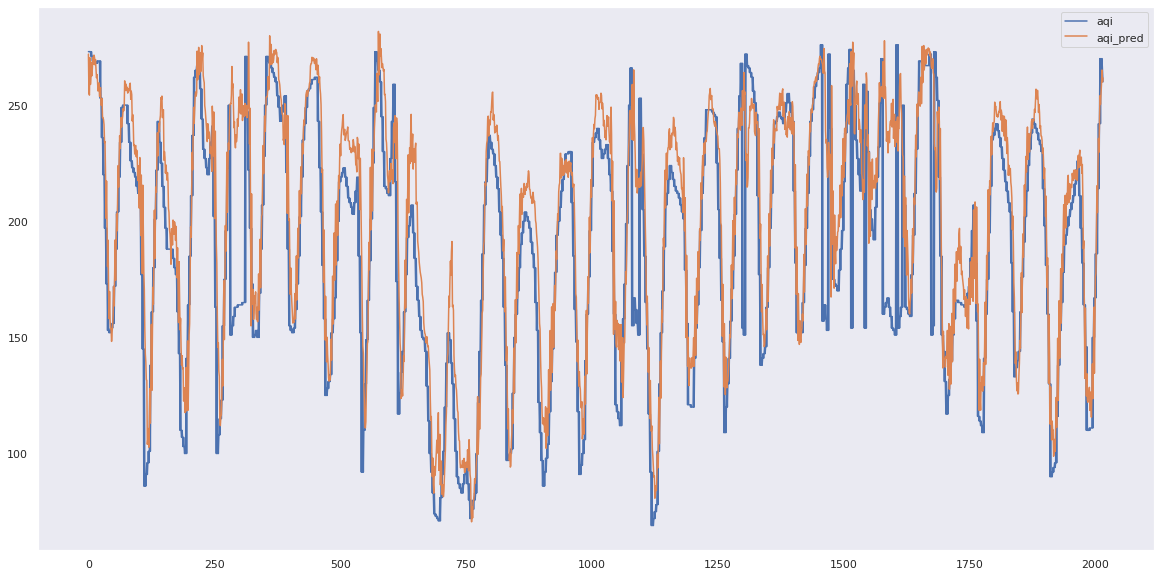

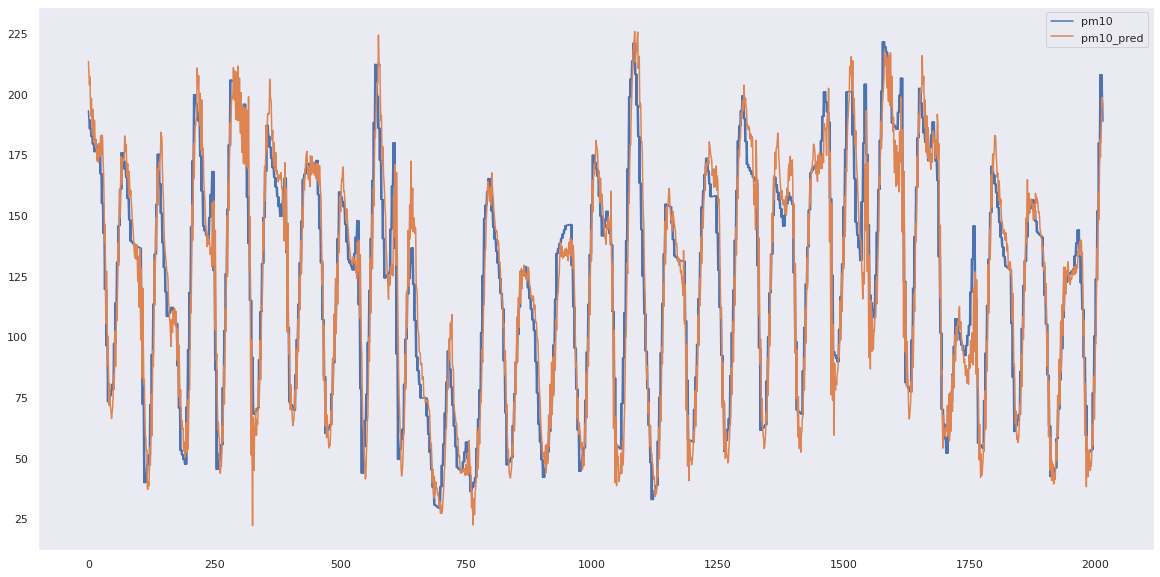

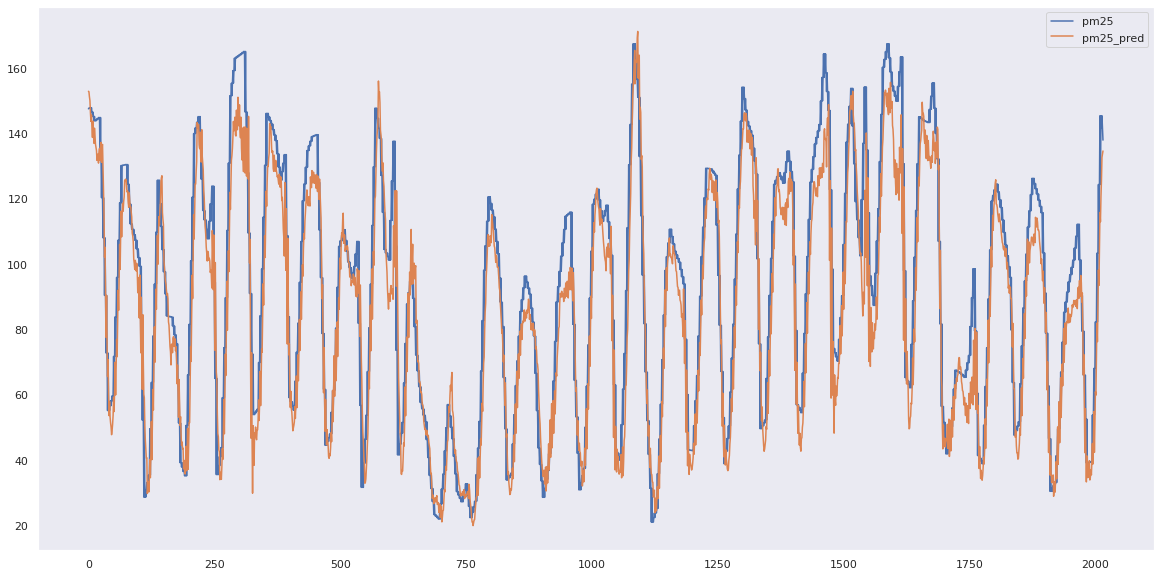

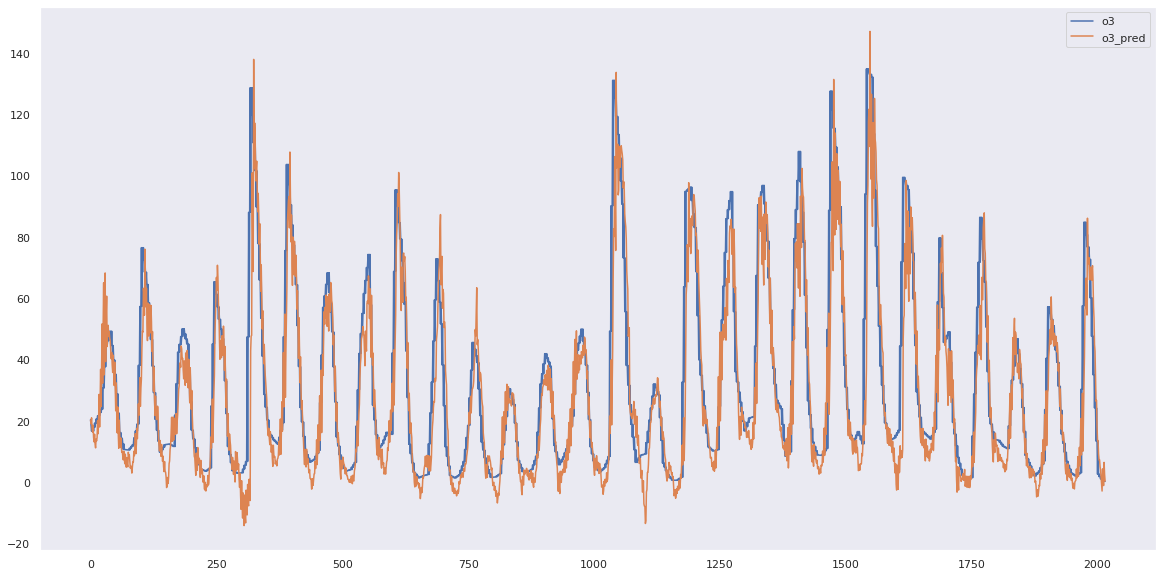

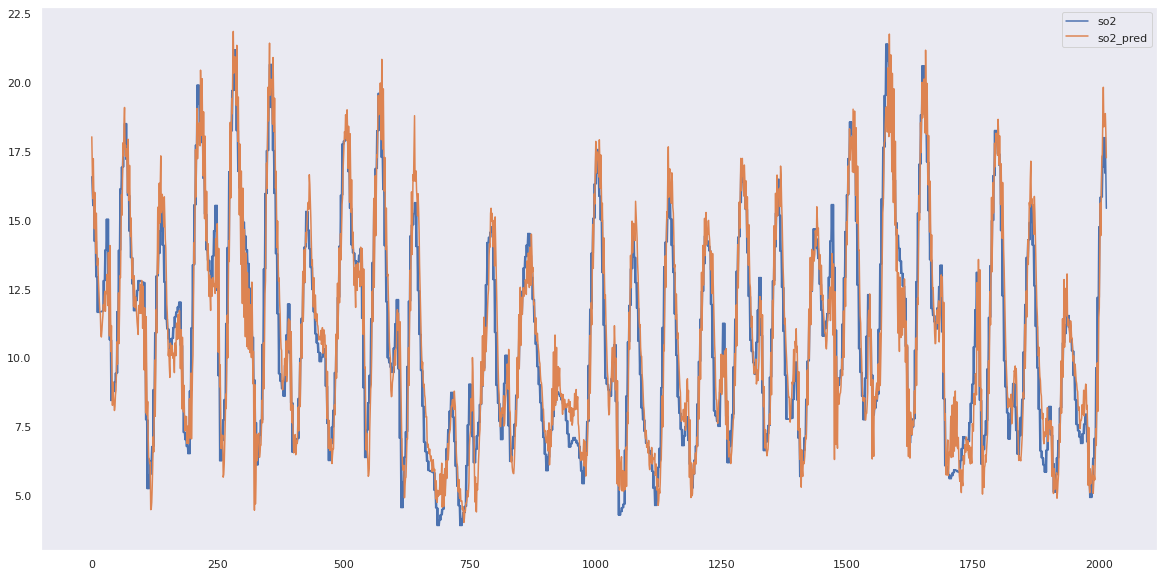

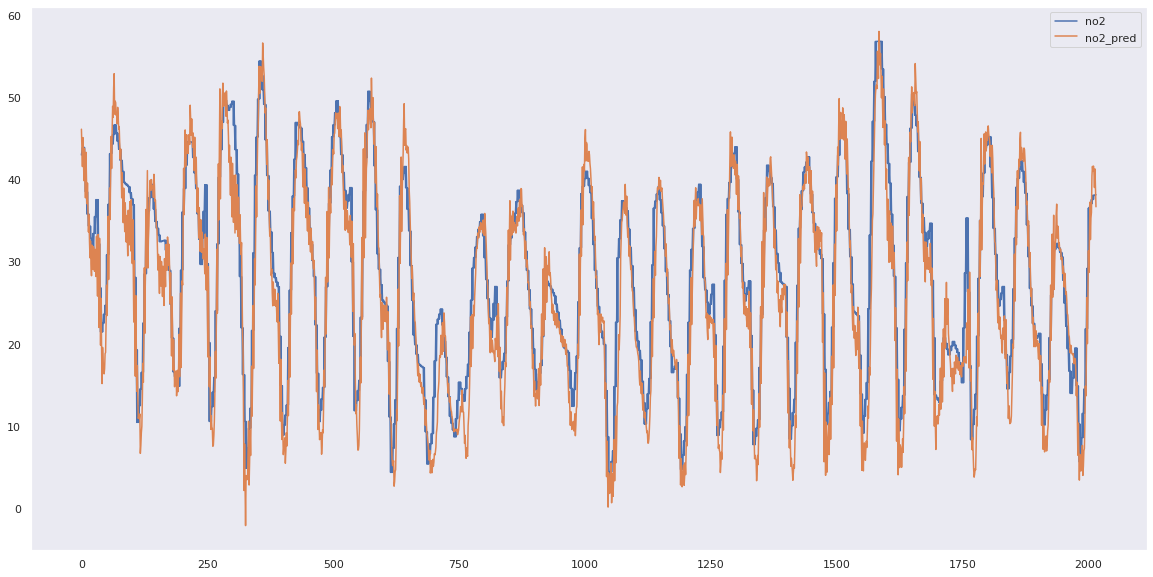

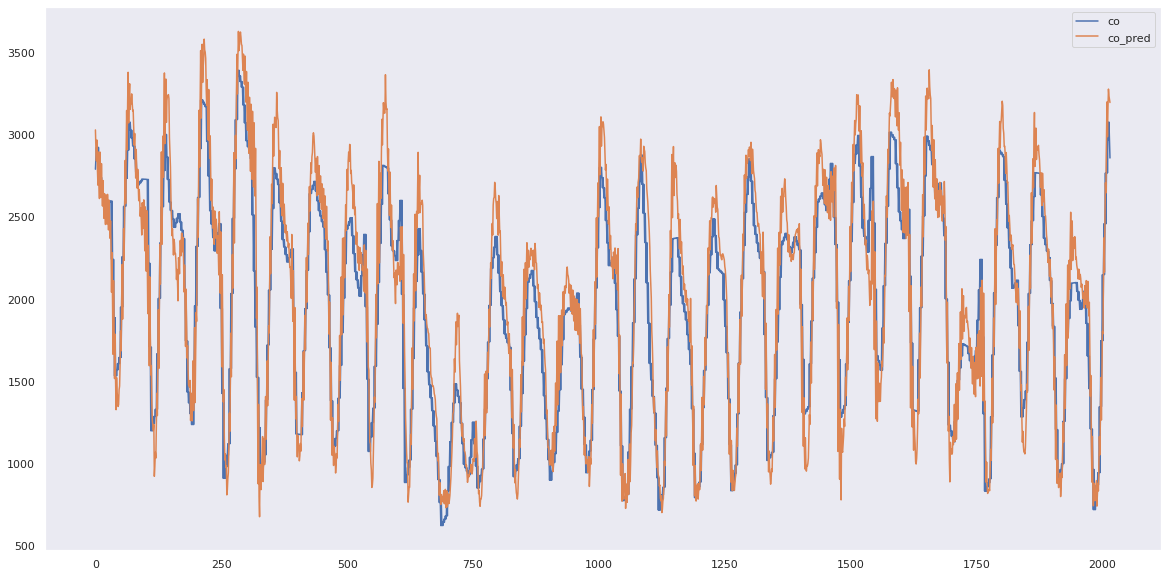

In [ ]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['axes.grid'] = False
df_final[['aqi', 'aqi_pred']].plot()
df_final[['pm10', 'pm10_pred']].plot()
df_final[['pm25', 'pm25_pred']].plot()
df_final[['o3', 'o3_pred']].plot()
df_final[['so2', 'so2_pred']].plot()
df_final[['no2', 'no2_pred']].plot()
df_final[['co', 'co_pred']].plot()

## error metric result

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

indicator = ['aqi', 'pm10', 'pm25', 'o3', 'so2', 'no2', 'co']
#print(f'n_step_in: {n_steps_in}, n_steps_out: {n_steps_out}, Epochs: {epoch}\n\n')
for i in indicator:
  rmse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_pred'], squared=False)
  mse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_pred'])
  mae = mean_absolute_error(df_final[f'{i}'], df_final[f'{i}_pred'])
  mape = mean_absolute_percentage_error(df_final[f'{i}'], df_final[f'{i}_pred'])
  print(f'{i} ----> RMSE: {rmse} ; MSE: {mse} ; MAE: {mae} ; MAPE: {mape}\n')

print('-----'*23)

aqi ----> RMSE: 27.986557212833496 ; MSE: 783.2473846272027 ; MAE: 19.099819501241047 ; MAPE: 0.11886997259191869

pm10 ----> RMSE: 14.022463999146915 ; MSE: 196.62949660737127 ; MAE: 10.440728158648053 ; MAPE: 0.10120770927087469

pm25 ----> RMSE: 11.776633739255344 ; MSE: 138.6891022285673 ; MAE: 9.142988767358991 ; MAPE: 0.11110815546073734

o3 ----> RMSE: 14.918077108041809 ; MSE: 222.54902460148105 ; MAE: 9.261688440691708 ; MAPE: 0.644320152443701

so2 ----> RMSE: 1.4305635894039825 ; MSE: 2.046512183328406 ; MAE: 1.1081615818209118 ; MAPE: 0.10571938866376443

no2 ----> RMSE: 4.176486848044347 ; MSE: 17.44304239188741 ; MAE: 3.2879898119445827 ; MAPE: 0.14118127037600617

co ----> RMSE: 170.19623230736596 ; MSE: 28966.757491622877 ; MAE: 130.24150871276856 ; MAPE: 0.0748985771935207

-------------------------------------------------------------------------------------------------------------------


# Save Model

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
model.save('my_model.h5')

INFO:tensorflow:Assets written to: saved_model/my_model/assets
